In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input , Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import regularizers
LABELS = ["Normal", "Fraud"]

# Detecção de Fraudes
Usei aqui nesse pequeno projeto o [Dataset do Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) para detecção de fraude. Aqui decidi usar 3 tipos de detectores: Uma Árvore de Decisão, uma Floresta Aleatória e um Autoencoder. Vamos ver qual desses três tem um melhor desempenho! 

In [2]:
df = pd.read_csv("..\Fraude_cartão_de_crédito\creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Dividindo em duas classes para fazermos uma pequena análise de dois features: O *Montante de dinheiro* em cada transação e o *tempo*

In [3]:
fraudes = df[df.Class == 1]
normal = df[df.Class == 0]

O montante tem uma forte influência nos dados. Vamos manter ele no data set! 

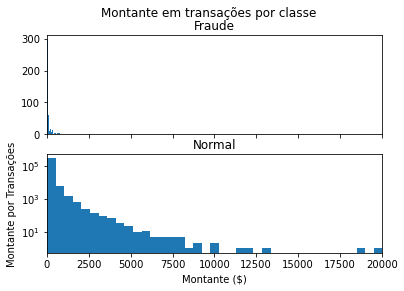

In [4]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Montante em transações por classe')
bins = 50
ax1.hist(fraudes.Amount, bins = bins)
ax1.set_title('Fraude')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Montante ($)')
plt.ylabel('Montante por Transações')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Aqui, percebemos que o tempo influencia as fraudes, por esse motivo, podemos dropalo da base de dados

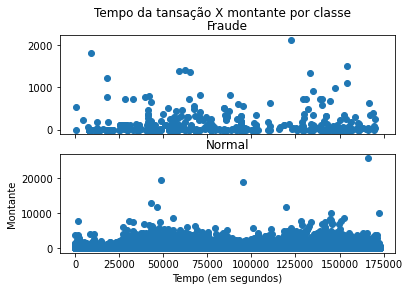

In [5]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Tempo da tansação X montante por classe')
ax1.scatter(fraudes.Time, fraudes.Amount)
ax1.set_title('Fraude')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Tempo (em segundos)')
plt.ylabel('Montante')
plt.show()

In [6]:
df = df.drop(["Time"], axis=1)

Separando os dados para treino e teste de ambas Árvore de Decisão e Floresta Aleatória

In [7]:
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test , y_train, y_test= train_test_split(X, y, test_size=0.3,random_state=300)
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


Criei uma função que mostra a métrica de cada modelo, para deixar o código o mais limpo possível

In [8]:
def mostra_metricas(y_true, y_pred):
  
  print("Accuracy: ", accuracy_score(y_true, y_pred))
  print("\nPrecission:", precision_score(y_true, y_pred))
  print("\nConfusion Matrix:")
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
  plt.show()

* Árvore de Decisão

Accuracy:  0.999204147794436

Precission: 0.7639751552795031

Confusion Matrix:


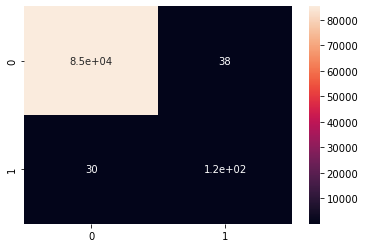

In [9]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
dtc_pred = dtc.predict(X_test)
mostra_metricas(y_test,dtc_pred)

* Floresta Aleatória

Accuracy:  0.9995435553526912

Precission: 0.9523809523809523

Confusion Matrix:


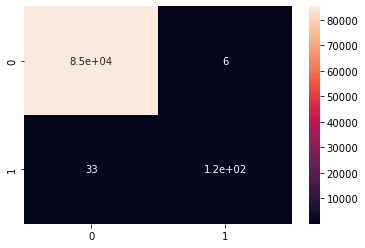

In [10]:
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
mostra_metricas(y_test, rfc_pred)

Para o *Autoencoder* vamos padronizar em escala de -1 até 1 a coluna "Amount" 

In [11]:
fraudes = df[df.Class == 1]
normal = df[df.Class == 0]
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
X_train, X_test = train_test_split(df, test_size=0.4, random_state=2000)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values


* #### O Autoencoder 

Autoencoder serve para fazer uma reconstrução dos inputs sejam imagens ou dados estruturados mesmo. 


[ Visualmente um autoencoder ](https://www.deeplearningbook.com.br/wp-content/uploads/2019/11/mushroom_encoder.png)

In [12]:
input_dim = X_train.shape[1]
encoding_dim = 16
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(1e-7))(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
encoder = Dense(4, activation=tf.nn.leaky_relu)(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(encoding_dim, activation= 'relu')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

In [13]:
nb_epoch = 50
batch_size = 128
checkpointer =ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               mode='min', monitor='val_loss',
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=8,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard, early_stop]).history

Epoch 1/50
1333/1333 [==============================] - 9s 6ms/step - loss: 0.8682 - accuracy: 0.3474 - val_loss: 0.8284 - val_accuracy: 0.4183
Epoch 2/50
1333/1333 [==============================] - 7s 5ms/step - loss: 0.7852 - accuracy: 0.4105 - val_loss: 0.7924 - val_accuracy: 0.4482
Epoch 3/50
1333/1333 [==============================] - 4s 3ms/step - loss: 0.7652 - accuracy: 0.4267 - val_loss: 0.7761 - val_accuracy: 0.4546
Epoch 4/50
1333/1333 [==============================] - 4s 3ms/step - loss: 0.7537 - accuracy: 0.4326 - val_loss: 0.7660 - val_accuracy: 0.4609
Epoch 5/50
1333/1333 [==============================] - 4s 3ms/step - loss: 0.7453 - accuracy: 0.4394 - val_loss: 0.7538 - val_accuracy: 0.4776
Epoch 6/50
1333/1333 [==============================] - 4s 3ms/step - loss: 0.7361 - accuracy: 0.4469 - val_loss: 0.7422 - val_accuracy: 0.4765
Epoch 7/50
1333/1333 [==============================] - 4s 3ms/step - loss: 0.7279 - accuracy: 0.4468 - val_loss: 0.7330 - val_accuracy:

Quanto maior a função de perda, maior a chance de ser uma anomalia, no nosso caso, de fraude 

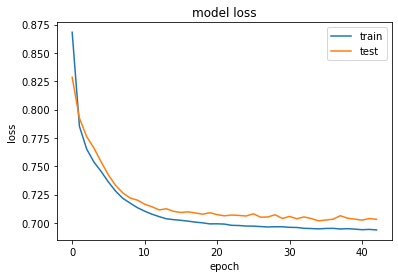

In [14]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [15]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,113923.000000,113923.000000
mean,0.701799,0.001606
std,6.741465,0.040047
min,0.021590,0.000000
25%,0.178842,0.000000
50%,0.295460,0.000000
75%,0.523417,0.000000
max,1841.714720,1.000000


In [16]:
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mse(reconstructions, X_train)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  4.054005816932914


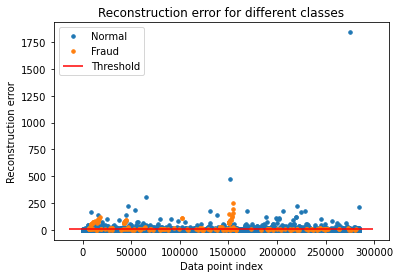

In [17]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

Accuracy:  0.9835502927415887

Precission: 0.07233181588265047

Confusion Matrix:


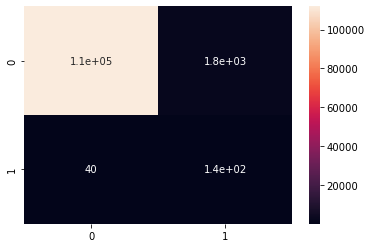

In [18]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
mostra_metricas(error_df.true_class, y_pred)

### Conclusões
Vimos que o melhor modelo foi a Floresta Aleatória, ja que obteve melhor precisão e acurácia. Além disso, vemos que o autoencoder trouxe uma grande quantidade de falsos-positivos, o que não queremos. 